In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

2023-02-05 21:48:06.595370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 21:48:06.770974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 21:48:06.770994: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 21:48:07.770248: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-05

In [2]:
#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(255*image1,255*image2)

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


In [4]:
data_path='data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')
images = np.reshape(images, (2000, 28, 28, 1))

In [5]:
dev = qml.device("default.qubit", wires=3)
# Random circuit parameters. Substitute random circuit with classifier for part 2
#rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 3))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 3 classical input values
    for j in range(3):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit. Substitute random circuit with classifier
    #RandomLayers(rand_params, wires=list(range(3)))

    # Measurement producing 3 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(3)]

In [6]:
def encode(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((28, 28, 3))

    # Loop over the coordinates of the top-left pixel of squares
    for j in range(0, 28, 1):
        for k in range(0, 28, 1):
            # Process a region of the image with a quantum circuit

            if j != 27 and k != 27:

                q_results = circuit(
                    [
                        image[j, k, 0],
                        image[j, k + 1, 0],
                        image[j + 1, k, 0],
                        #image[j + 1, k + 1, 0]
                    ]
                )

            if j == 27 or k == 27:
                q_results = circuit(
                    [
                        image[j, k, 0],
                        image[j, k, 0],
                        image[j, k, 0],
                        #image[j, k, 0]
                    ]
                )

            # Assign expectation values to different channels of the output pixel
            for c in range(3):
                out[j, k, c] = q_results[c]
    return out


In [9]:
n_samples = 4
n_channels = 3

q_train_images = []
n_train = 4
print("Quantum pre-processing of train images:")
for idx, img in enumerate(images):
    if idx >= n_train:
        break

    print("{}/{}        ".format(idx + 1, n_train), end="\r")
    q_train_images.append(encode(img))


q_train_images = np.asarray(q_train_images)

def decode(): 
    #inverting pixel intensities from circuit.
    for k in range(n_samples):
        for c in range(n_channels):
            q_train_images[k, :, :, c] = np.max(q_train_images[k, :, :, c]) - q_train_images[k, :, :, c]

decode()

Quantum pre-processing of train images:


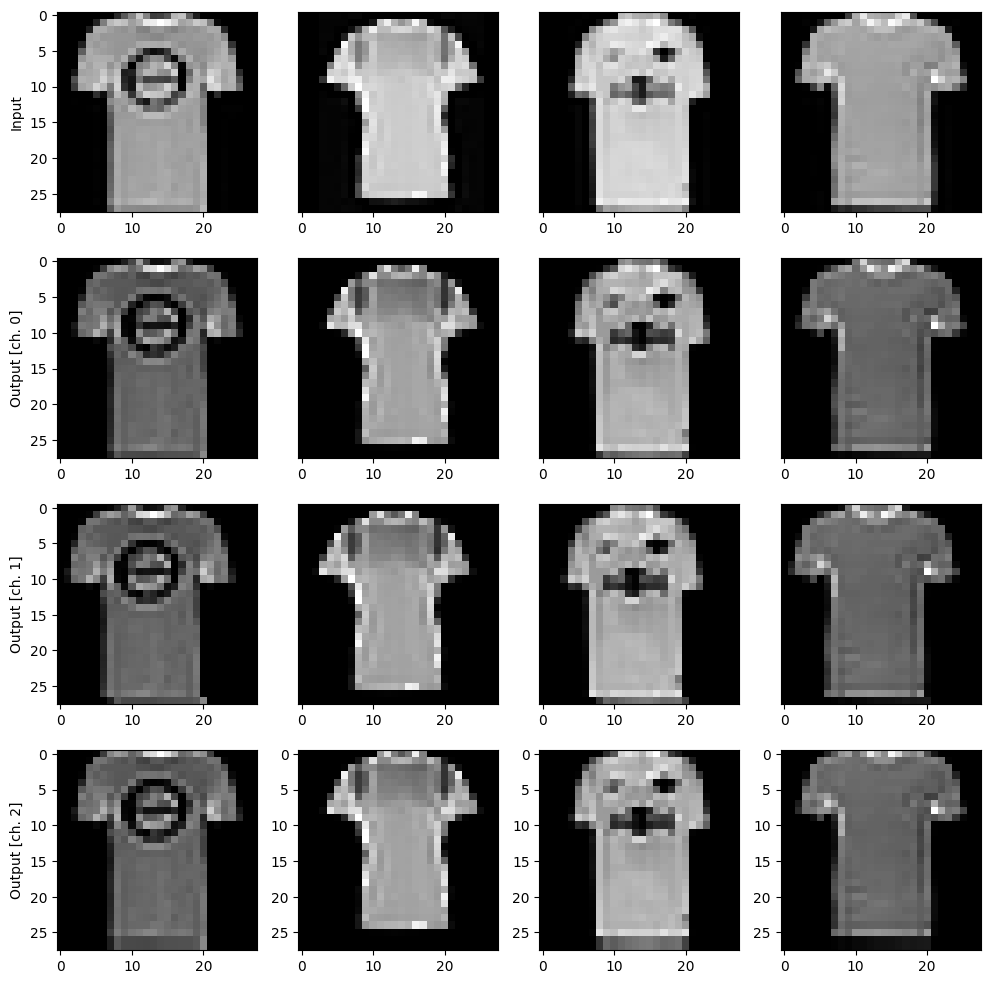

In [10]:

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()



In [12]:
#how we grade your submission

n=n_samples
mse=0
#no. of gates from circuit
gatecount=3
channel=0

for k in range(n_samples):
    
    #calculate mse
    mse+=image_mse(images[k, :, :, 0], q_train_images[k, :, :, channel])
    
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1 
print(f*(0.999**gatecount))

0.7471439422232253
